In [1]:
import pandas as pd
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import math

In [2]:
dataset = pd.read_csv('project_data.csv', index_col= 0, parse_dates= True)

In [3]:
dataset.head()

MSFT        AAPL       NVDA       GOOGL        AMZN  \
Date                                                                    
2022-01-03  326.940765  179.273605  30.073063  144.633362  170.404495   
2022-01-04  321.334717  176.998337  29.243385  144.042831  167.522003   
2022-01-05  308.999390  172.290192  27.560064  137.434677  164.356995   
2022-01-06  306.557648  169.414108  28.133152  137.407257  163.253998   
2022-01-07  306.713989  169.581558  27.203632  136.678558  162.554001   

                  META       BRK-B         LLY       AVGO        TSLA  ...  \
Date                                                                   ...   
2022-01-03  337.523743  300.790009  264.163483  62.166073  399.926666  ...   
2022-01-04  335.519806  308.529999  259.380493  62.878334  383.196655  ...   
2022-01-05  323.196899  309.920013  253.391998  60.261692  362.706665  ...   
2022-01-06  331.462006  313.220001  252.108810  59.702183  354.899994  ...   
2022-01-07  330.794006  319.779999  252.274048  58.026482  342.320007  ...   

                 GILD         AMT         HCA       INTC          CI  \
Date                                                                   
2022-01-03  64.746964  263.336456  247.806747  49.350491  223.533035   
2022-01-04  64.416885  260.016968  253.843887  49.285561  222.674011   
2022-01-05  64.390137  243.281403  252.576019  49.962608  225.747345   
2022-01-06  63.863789  243.575684  248.226135  50.092457  217.176346   
2022-01-07  63.569416  245.129684  245.982941  49.563797  222.559479   

                 PLTR         SHW       MDLZ         ICE          BA  
Date                                                                  
2022-01-03  18.530001  330.448730  61.801727  128.829361  207.860001  
2022-01-04  18.170000  327.135681  62.251400  128.944763  213.630005  
2022-01-05  16.959999  327.749542  63.150738  127.328995  213.070007  
2022-01-06  16.740000  325.030945  63.122631  128.069550  211.339996  
2022-01-07  16.559999  314.955292  63.281902  128.156113  215.500000  

[5 rows x 75 columns]

## Sample stock plot

<Axes: xlabel='Date'>

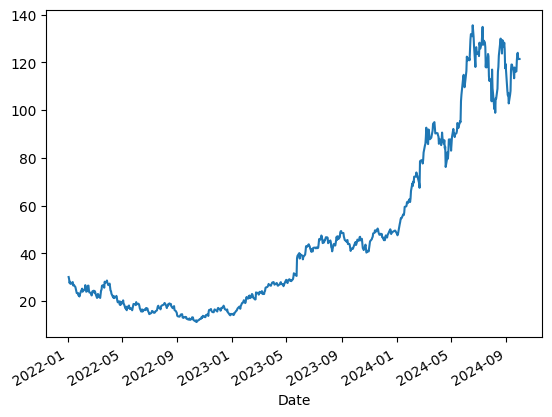

In [94]:
dataset['NVDA'].plot()

## Empirical Efficient Frontier 

In [4]:

## Define efficient frontier function
def efficient_frontier(data): 
    num_assets = len(data.columns)

    log_return = np.log(data/data.shift(1)).dropna()
    mu = log_return.mean()*252
    mu = mu.values.reshape(-1,1)
    q = log_return.cov()*252

    # Initialize a list to store volatility values for different R
    vol_eff_front = []
    largest_weights = []  
    weights_series = []
    for r in np.arange(0,4,0.005):

        w = cp.Variable(num_assets)

        # Define the constraints 
        constraints = [
            cp.sum(w) == 1,       # Sum of weights should equal 1
            mu.T @ w == r,        # Expected return constraint
            w >= -1,              # Lower bound for short selling
            w <= 1              # Upper bound of 1 for each weight
        ]
        
        # Formulate the optimization problem (minimizing variance: w.T(Q@w))
        objective = cp.Minimize(cp.quad_form(w, q))
        problem = cp.Problem(objective, constraints)
        # Solve the problem
        result = problem.solve()
        # Append the standard deviation (volatility) to the list
        vol_eff_front.append(np.sqrt(result))
        
        w_values = w.value
        weights_series.append(w_values)
        w_series = pd.Series(w_values, index=data.columns)
        top_weights = w_series.sort_values(ascending=False).head(5)
        largest_weights.append(top_weights)

    min_vol_index = np.argmin(vol_eff_front)  # Index of minimum volatility
    gmvp_weights = weights_series[min_vol_index]  # Corresponding weights for GMVP
    # Assume threshold return = 0.5
    threshold_weight = weights_series[int(0.5/0.005-1)]

    return vol_eff_front, largest_weights, gmvp_weights, threshold_weight

Text(0.5, 1.0, 'Efficient Frontier')

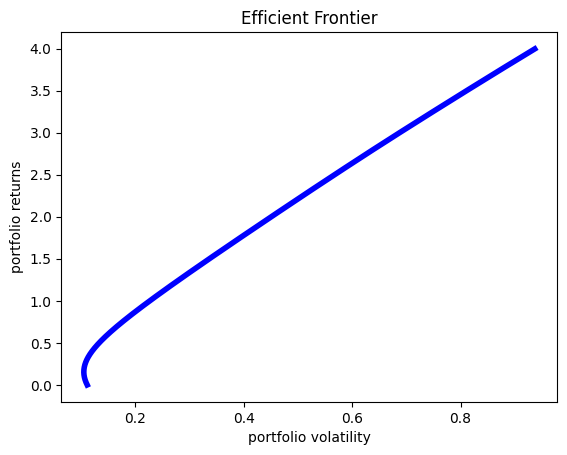

In [288]:
x = efficient_frontier(dataset)
plt.plot(x[0], np.arange(0,4,0.005), 'b', lw = 4)
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio returns')
plt.title('Efficient Frontier')

## Test stability, implement a rolling window
#### Invest a new portfolio every quarter 
##### rolling window = 3 months

In [5]:
start_date = pd.to_datetime("2022-01-01")  # Initial start date
end_date = start_date + pd.DateOffset(months=12)- pd.DateOffset(days=1)
rolling_window = []
end_date_index = []
end_date_index.append(end_date)
while end_date <= dataset.index.max():
    # Filter the DataFrame for the current 12-month window
    current_window = dataset[(dataset.index >= start_date) & (dataset.index < end_date)]
    rolling_window.append(current_window)
    # Move the start and end date forward by 3 months for the next window
    start_date += pd.DateOffset(months=3)
    end_date += pd.DateOffset(months=3)
    end_date_index.append(end_date)

In [6]:
end_date_index = end_date_index[:-1]
end_date_index

[Timestamp('2022-12-31 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 Timestamp('2023-09-30 00:00:00'),
 Timestamp('2023-12-30 00:00:00'),
 Timestamp('2024-03-30 00:00:00'),
 Timestamp('2024-06-30 00:00:00'),
 Timestamp('2024-09-30 00:00:00')]

In [556]:
len(rolling_window)

8

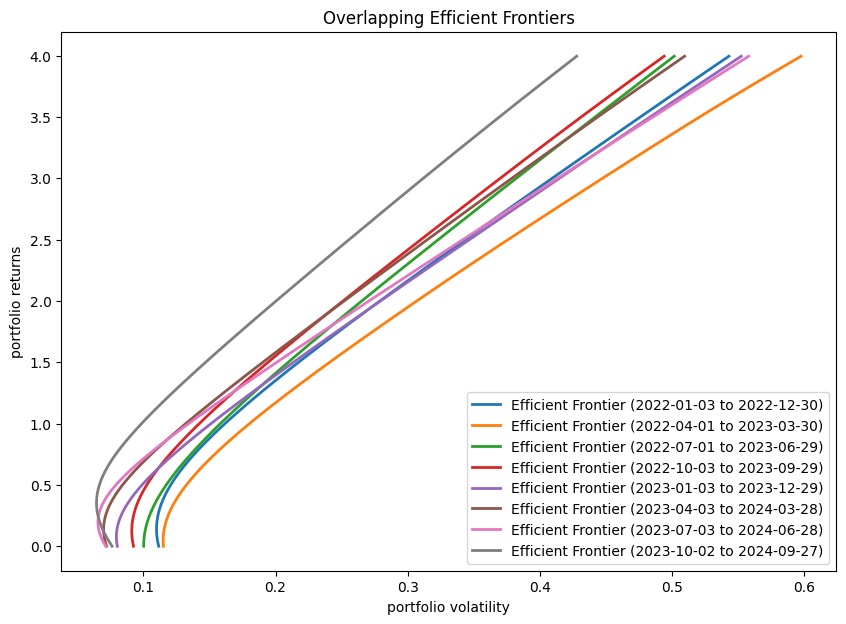

In [557]:
plt.figure(figsize=(10, 7))  # Set a suitable figure size for the combined plot
optimal_weight = []
for i in range(len(rolling_window)):
    x = efficient_frontier(rolling_window[i])
    # Generate start and end dates for the labels
    start_date_str = rolling_window[i].index.min().strftime('%Y-%m-%d')
    end_date_str = rolling_window[i].index.max().strftime('%Y-%m-%d')
    
    # Plot each efficient frontier on the same plot with a different label for identification
    plt.plot(x[0] , np.arange(0, 4, 0.005), lw=2, label=f"Efficient Frontier ({start_date_str} to {end_date_str})")
    optimal_weight.append(x[3])
# Add labels and title
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio returns')
plt.title('Overlapping Efficient Frontiers')
# Add a legend to differentiate the frontiers
plt.legend()
# Show the plot
plt.show()

<Figure size 1400x2000 with 0 Axes>

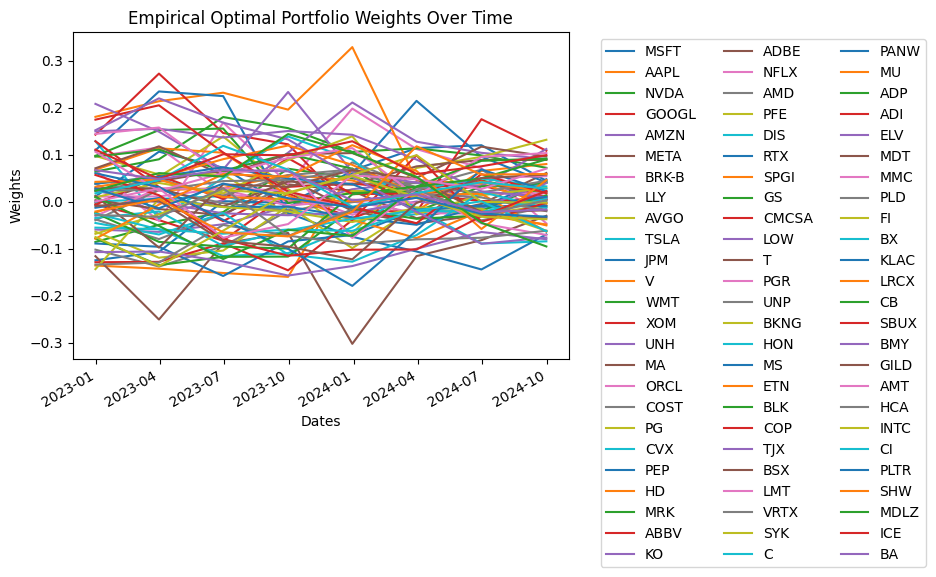

In [558]:
weight_df = pd.DataFrame(optimal_weight,index = end_date_index,columns= dataset.columns)
plt.figure(figsize = (14,20))
weight_df.plot(title='Empirical Optimal Portfolio Weights Over Time')
plt.xlabel('Dates')
plt.ylabel('Weights')
#plt.legend().set_visible(False)
plt.legend(dataset.columns, bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 3) 
plt.show()

<Axes: >

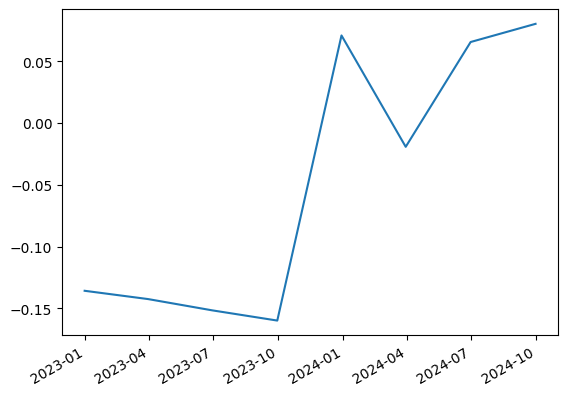

In [559]:
weight_df['AAPL'].plot()

In [560]:
weight_df

MSFT      AAPL      NVDA     GOOGL      AMZN      META  \
2022-12-31  0.010980 -0.135725 -0.085511 -0.005980 -0.059197 -0.002524   
2023-03-31  0.106353 -0.142433 -0.049126 -0.039166 -0.064154  0.043680   
2023-06-30  0.072251 -0.151558 -0.022095 -0.082963 -0.047981  0.066274   
2023-09-30 -0.012668 -0.159798  0.070141  0.017313 -0.010181  0.036916   
2023-12-30  0.066424  0.070667  0.049544 -0.034956  0.026520  0.023072   
2024-03-30  0.113926 -0.019352  0.030756  0.014571  0.041907 -0.035303   
2024-06-30  0.120090  0.065365  0.045099  0.034155  0.000412 -0.004679   
2024-09-30  0.044430  0.080059  0.017476  0.003482  0.007165  0.060970   

               BRK-B       LLY      AVGO      TSLA  ...      GILD       AMT  \
2022-12-31  0.067086 -0.037580  0.097327  0.000180  ... -0.009258  0.000476   
2023-03-31 -0.040910 -0.079495  0.057836  0.005881  ...  0.002163  0.028224   
2023-06-30  0.168217 -0.025641  0.058068  0.011763  ... -0.083799 -0.076593   
2023-09-30  0.038462  0.032719 -0.027405 -0.018217  ... -0.095545 -0.047553   
2023-12-30  0.197984  0.037519  0.022769 -0.036234  ... -0.122486  0.055993   
2024-03-30  0.111899  0.039561  0.022184 -0.026625  ... -0.002611  0.047566   
2024-06-30  0.071231  0.042993 -0.026991 -0.015228  ...  0.049981  0.027057   
2024-09-30 -0.046000  0.003789 -0.008101  0.000077  ...  0.057719  0.070311   

                 HCA      INTC        CI      PLTR       SHW      MDLZ  \
2022-12-31 -0.028408 -0.075173  0.017953  0.027619 -0.020808  0.023394   
2023-03-31 -0.032197 -0.136871  0.045647 -0.013976  0.005315  0.060794   
2023-06-30  0.028600 -0.061548  0.118817  0.038590 -0.065065  0.053517   
2023-09-30 -0.073012  0.019541  0.067999  0.007523 -0.073804  0.143806   
2023-12-30 -0.016132  0.054973 -0.010726 -0.012310 -0.021349  0.104099   
2024-03-30  0.025949  0.009711  0.018300  0.008336  0.117779  0.052949   
2024-06-30 -0.027922 -0.032194  0.041382 -0.025292  0.057694 -0.044738   
2024-09-30  0.003187 -0.037364  0.027864 -0.031705  0.058897 -0.095141   

                 ICE        BA  
2022-12-31  0.110719  0.067170  
2023-03-31  0.048006  0.047944  
2023-06-30  0.100875  0.067726  
2023-09-30  0.098460  0.064537  
2023-12-30  0.128485  0.002805  
2024-03-30  0.058937  0.015721  
2024-06-30  0.075307 -0.022337  
2024-09-30  0.099075 -0.016739  

[8 rows x 75 columns]

Text(0.5, 1.0, 'Weightage Standard Deviation for Basic Efficient Frontier')

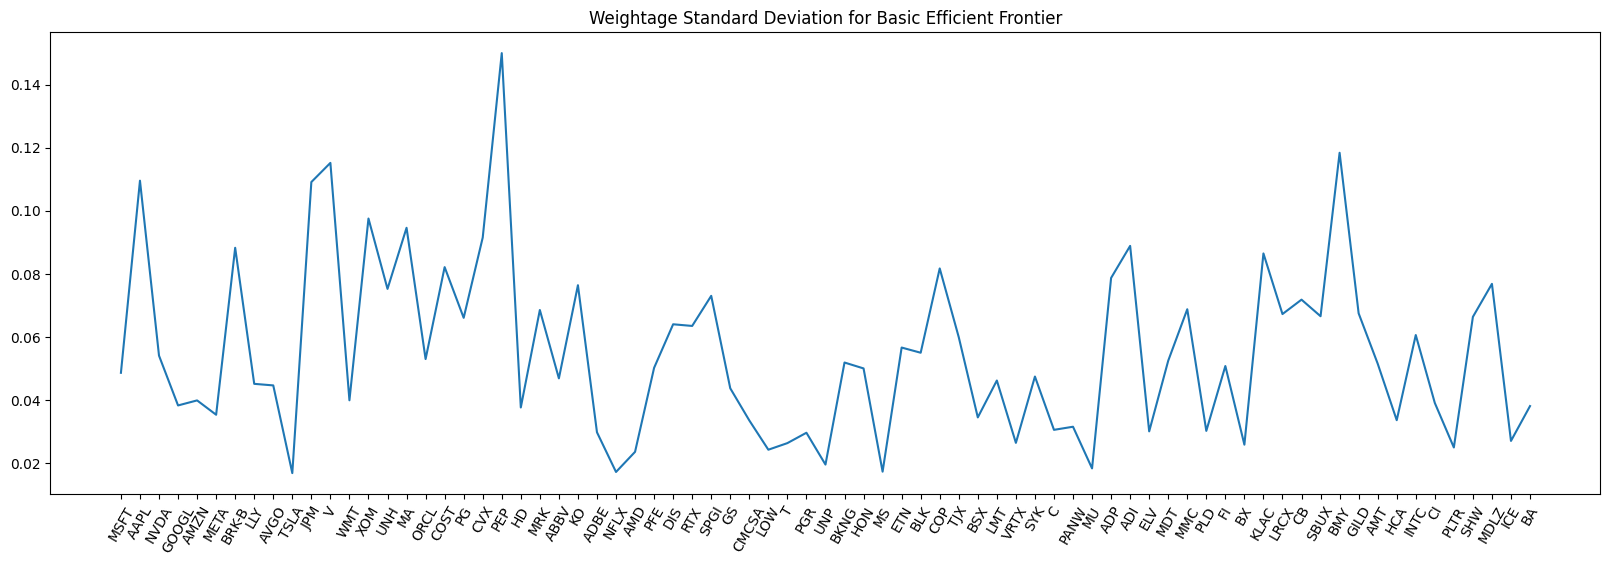

In [561]:
weight_std = weight_df.std()
plt.figure(figsize=(20, 6))
weight_std.plot()
plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
plt.title('Weightage Standard Deviation for Basic Efficient Frontier')

In [562]:
weight_std

MSFT     0.048648
AAPL     0.109532
NVDA     0.054087
GOOGL    0.038306
AMZN     0.039902
           ...   
PLTR     0.024985
SHW      0.066372
MDLZ     0.076839
ICE      0.027063
BA       0.038107
Length: 75, dtype: float64

## Leboit-Wolf Shrinkage

In [10]:
from sklearn.covariance import LedoitWolf

In [563]:

## Define efficient frontier function
def lw_efficient_frontier(data): 
    num_assets = len(data.columns)

    log_return = np.log(data/data.shift(1)).dropna()
    mu = log_return.mean()*252
    mu = mu.values.reshape(-1,1)
    lw = LedoitWolf()
    lw_cov = lw.fit(log_return).covariance_*252
    lw_cov = pd.DataFrame(lw_cov, index = data.columns, columns = data.columns)

    # Initialize a list to store volatility values for different R
    vol_eff_front = []
    largest_weights = []  
    weights_series = []
    for r in np.arange(0,4,0.005):

        w = cp.Variable(num_assets)

        # Define the constraints 
        constraints = [
            cp.sum(w) == 1,       # Sum of weights should equal 1
            mu.T @ w == r,        # Expected return constraint
            w >= -1,              # Lower bound for short selling
            w <= 1              # Upper bound of 1 for each weight
        ]
        
        # Formulate the optimization problem (minimizing variance: w.T(Q@w))
        objective = cp.Minimize(cp.quad_form(w, lw_cov))
        problem = cp.Problem(objective, constraints)
        # Solve the problem
        result = problem.solve()
        # Append the standard deviation (volatility) to the list
        vol_eff_front.append(np.sqrt(result))
        
        w_values = w.value
        weights_series.append(w_values)
        w_series = pd.Series(w_values, index=data.columns)
        top_weights = w_series.sort_values(ascending=False).head(5)
        largest_weights.append(top_weights)

    min_vol_index = np.argmin(vol_eff_front)  # Index of minimum volatility
    gmvp_weights = weights_series[min_vol_index]  # Corresponding weights for GMVP
    # Assume threhold return = 0.5
    threhold_weight = weights_series[int(0.5/0.005-1)]

    return vol_eff_front, largest_weights, gmvp_weights, threhold_weight

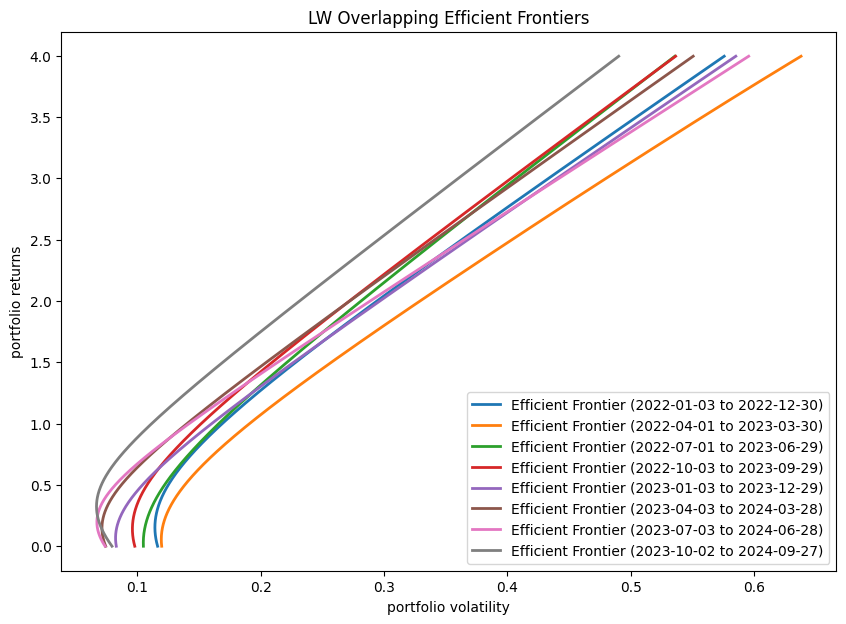

In [564]:
plt.figure(figsize=(10, 7))  # Set a suitable figure size for the combined plot
optimal_weight_lw = []
for i in range(len(rolling_window)):
    x = lw_efficient_frontier(rolling_window[i])
    
    # Generate start and end dates for the labels
    start_date_str = rolling_window[i].index.min().strftime('%Y-%m-%d')
    end_date_str = rolling_window[i].index.max().strftime('%Y-%m-%d')
    
    # Plot each efficient frontier on the same plot with a different label for identification
    plt.plot(x[0] , np.arange(0, 4, 0.005), lw=2, label=f"Efficient Frontier ({start_date_str} to {end_date_str})")
    optimal_weight_lw.append(x[3])
# Add labels and title
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio returns')
plt.title('LW Overlapping Efficient Frontiers')
# Add a legend to differentiate the frontiers
plt.legend()
# Show the plot
plt.show()

<Figure size 1400x2000 with 0 Axes>

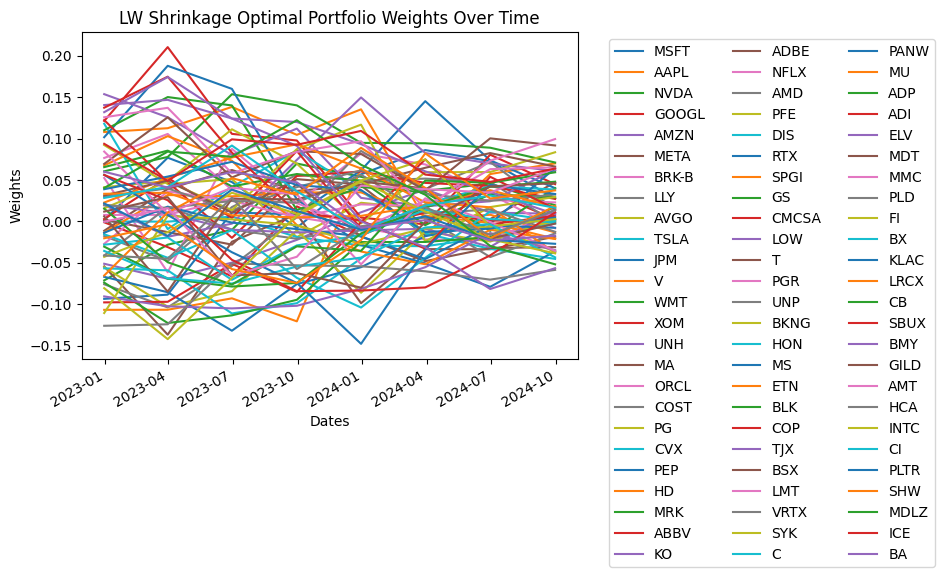

In [565]:
weight_df_lw = pd.DataFrame(optimal_weight_lw,index = end_date_index,columns= dataset.columns)
plt.figure(figsize = (14,20))
weight_df_lw.plot(title='LW Shrinkage Optimal Portfolio Weights Over Time')
plt.xlabel('Dates')
plt.ylabel('Weights')
#plt.legend().set_visible(False)
plt.legend(dataset.columns, bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 3) 
plt.show()

Text(0.5, 1.0, 'Weightage Standard Deviation for LW Efficient Frontier')

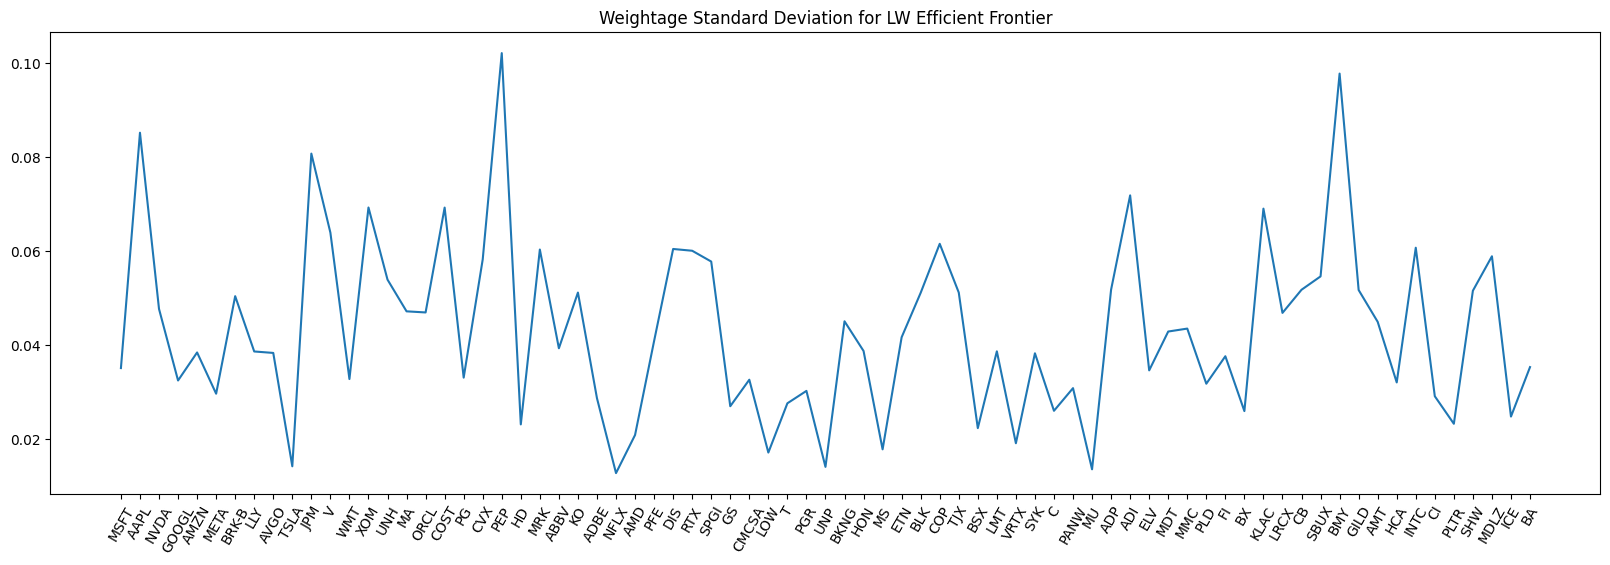

In [566]:
weight_lw_std = weight_df_lw.std()
plt.figure(figsize=(20, 6))
weight_lw_std.plot()
plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
plt.title('Weightage Standard Deviation for LW Efficient Frontier')

## MCD method (Omitted)

In [11]:
from sklearn.covariance import MinCovDet

In [308]:

# ## Define efficient frontier function using MCD
# def mcd_efficient_frontier(data): 
#     num_assets = len(data.columns)

#     log_return = np.log(data/data.shift(1)).dropna()
#     mu = log_return.mean() * 252
#     mu = mu.values.reshape(-1, 1)
    
#     # Compute the covariance matrix using Minimum Covariance Determinant (MCD)
#     mcd = MinCovDet()
#     mcd_cov = mcd.fit(log_return).covariance_ * 252
#     mcd_cov = pd.DataFrame(mcd_cov, index=data.columns, columns=data.columns)

#     # Initialize lists to store volatility values and weights for different R
#     vol_eff_front = []
#     largest_weights = []  
#     weights_series = []
    
#     # Efficient frontier loop over different expected returns
#     for r in np.arange(0, 4, 0.005):
#         w = cp.Variable(num_assets)

#         # Define constraints
#         constraints = [
#             cp.sum(w) == 1,        # Sum of weights should equal 1
#             mu.T @ w == r,         # Expected return constraint
#             w >= -1,               # Lower bound for short selling
#             w <= 1                 # Upper bound of 1 for each weight
#         ]
        
#         # Formulate the optimization problem (minimizing variance: w.T @ (MCD covariance) @ w)
#         objective = cp.Minimize(cp.quad_form(w, mcd_cov))
#         problem = cp.Problem(objective, constraints)
        
#         # Solve the problem
#         result = problem.solve()
        
#         # Append the standard deviation (volatility) to the list
#         vol_eff_front.append(np.sqrt(result))
        
#         # Store weights for each portfolio
#         w_values = w.value
#         weights_series.append(w_values)
        
#         # Store top weights for optional visualization
#         w_series = pd.Series(w_values, index=data.columns)
#         top_weights = w_series.sort_values(ascending=False).head(5)
#         largest_weights.append(top_weights)

#     # Find the GMVP weights
#     min_vol_index = np.argmin(vol_eff_front)   # Index of minimum volatility
#     gmvp_weights = weights_series[min_vol_index]  # Corresponding weights for GMVP
    
#     # Retrieve weights at a threshold return of 0.5
#     threshold_index = int(0.2 / 0.005 - 1)
#     threshold_weight = weights_series[threshold_index]

#     return vol_eff_front, largest_weights, gmvp_weights, threshold_weight


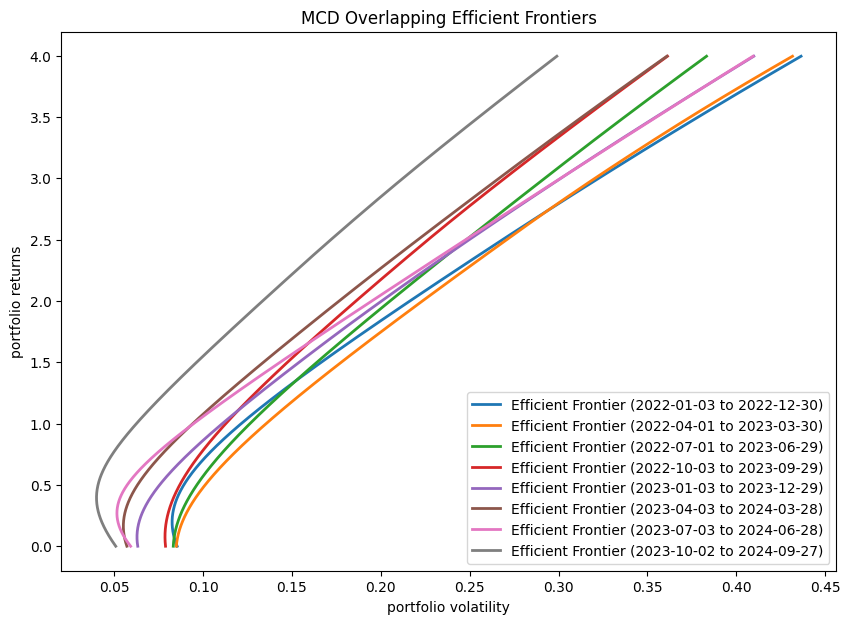

In [309]:
# plt.figure(figsize=(10, 7))  # Set a suitable figure size for the combined plot
# optimal_weight_mcd = []
# for i in range(len(rolling_window)):
#     x = mcd_efficient_frontier(rolling_window[i])
    
#     # Generate start and end dates for the labels
#     start_date_str = rolling_window[i].index.min().strftime('%Y-%m-%d')
#     end_date_str = rolling_window[i].index.max().strftime('%Y-%m-%d')
    
#     # Plot each efficient frontier on the same plot with a different label for identification
#     plt.plot(x[0] , np.arange(0, 4, 0.005), lw=2, label=f"Efficient Frontier ({start_date_str} to {end_date_str})")
#     optimal_weight_mcd.append(x[3])
# # Add labels and title
# plt.xlabel('portfolio volatility')
# plt.ylabel('portfolio returns')
# plt.title('MCD Overlapping Efficient Frontiers')
# # Add a legend to differentiate the frontiers
# plt.legend()
# # Show the plot
# plt.show()

<Figure size 1400x2000 with 0 Axes>

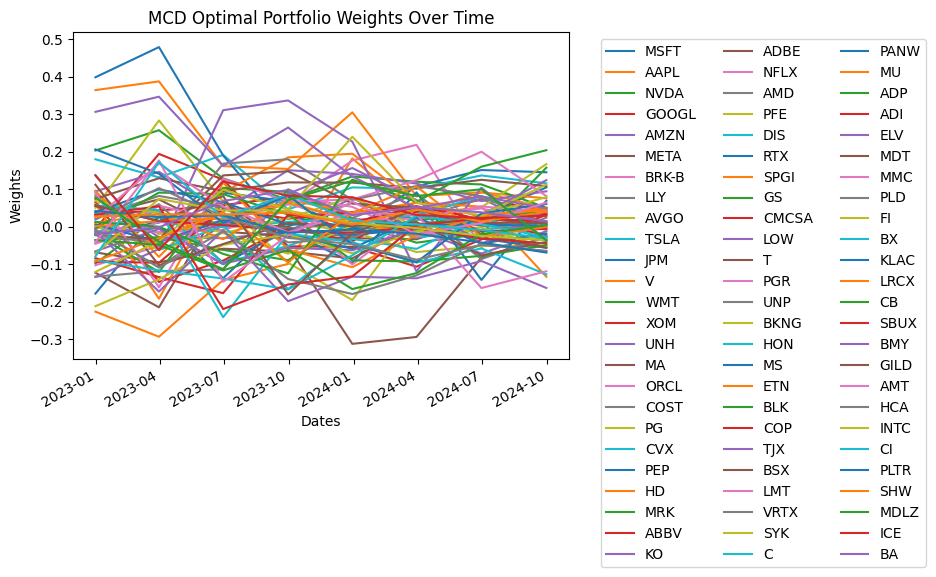

In [310]:
# weight_df_mcd = pd.DataFrame(optimal_weight_mcd,index = end_date_index,columns= dataset.columns)
# plt.figure(figsize = (14,20))
# weight_df_mcd.plot(title='MCD Optimal Portfolio Weights Over Time')
# plt.xlabel('Dates')
# plt.ylabel('Weights')
# #plt.legend().set_visible(False)
# plt.legend(dataset.columns, bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 3) 
# plt.show()

Text(0.5, 1.0, 'Weightage Standard Deviation for Basic Efficient Frontier')

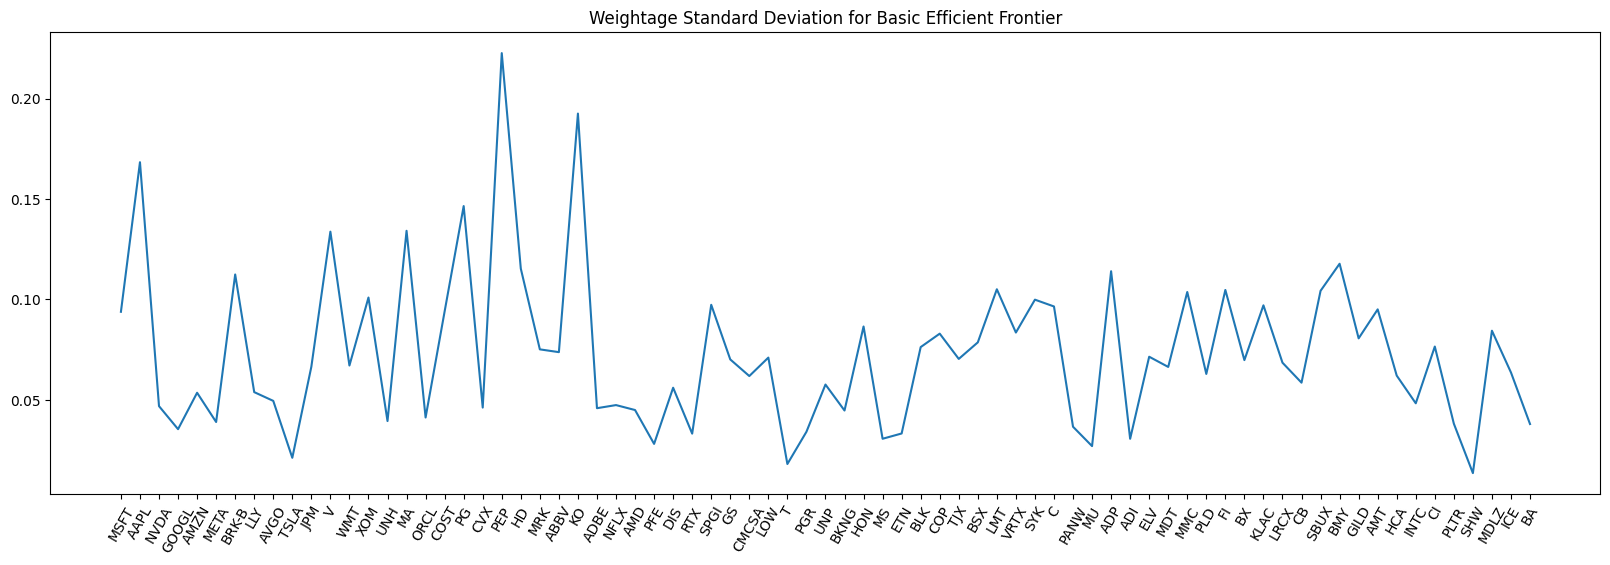

In [311]:
# weight_mcd_std = weight_df_mcd.std()
# plt.figure(figsize=(20, 6))
# weight_mcd_std.plot()
# plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
# plt.title('Weightage Standard Deviation for MCD Efficient Frontier')

## Combine method
### Since MCD result is undesired, we combine MCD and LW approaches together to further modify a stable covariance matrix

In [567]:
## Define efficient frontier function using MCD
def mcd_lw_efficient_frontier(data): 
    num_assets = len(data.columns)

    log_return = np.log(data/data.shift(1)).dropna()
    mu = log_return.mean() * 252
    mu = mu.values.reshape(-1, 1)
    
    # Compute the covariance matrix using Minimum Covariance Determinant (MCD) and LW
    mcd = MinCovDet()
    mcd_cov = mcd.fit(log_return).covariance_ * 252
    mcd_cov = pd.DataFrame(mcd_cov, index=data.columns, columns=data.columns)
    lw = LedoitWolf()
    lw.fit(mcd_cov)
    combined_covariance = lw.covariance_
    combined_covariance_df = pd.DataFrame(combined_covariance, index=data.columns, columns=data.columns)

    # Initialize lists to store volatility values and weights for different R
    vol_eff_front = []
    largest_weights = []  
    weights_series = []
    
    # Efficient frontier loop over different expected returns
    for r in np.arange(0, 4, 0.005):
        w = cp.Variable(num_assets)

        # Define constraints
        constraints = [
            cp.sum(w) == 1,        # Sum of weights should equal 1
            mu.T @ w == r,         # Expected return constraint
            w >= -1,               # Lower bound for short selling
            w <= 1                 # Upper bound of 1 for each weight
        ]
        
        # Formulate the optimization problem (minimizing variance: w.T @ (MCD covariance) @ w)
        objective = cp.Minimize(cp.quad_form(w, combined_covariance_df))
        problem = cp.Problem(objective, constraints)
        
        # Solve the problem
        result = problem.solve()
        
        # Append the standard deviation (volatility) to the list
        vol_eff_front.append(np.sqrt(result))
        
        # Store weights for each portfolio
        w_values = w.value
        weights_series.append(w_values)
        
        # Store top weights for optional visualization
        w_series = pd.Series(w_values, index=data.columns)
        top_weights = w_series.sort_values(ascending=False).head(5)
        largest_weights.append(top_weights)

    # Find the GMVP weights
    min_vol_index = np.argmin(vol_eff_front)   # Index of minimum volatility
    gmvp_weights = weights_series[min_vol_index]  # Corresponding weights for GMVP
    
    # Retrieve weights at a threshold return of 0.5
    threshold_index = int(0.5 / 0.005 - 1)
    threshold_weight = weights_series[threshold_index]

    return vol_eff_front, largest_weights, gmvp_weights, threshold_weight


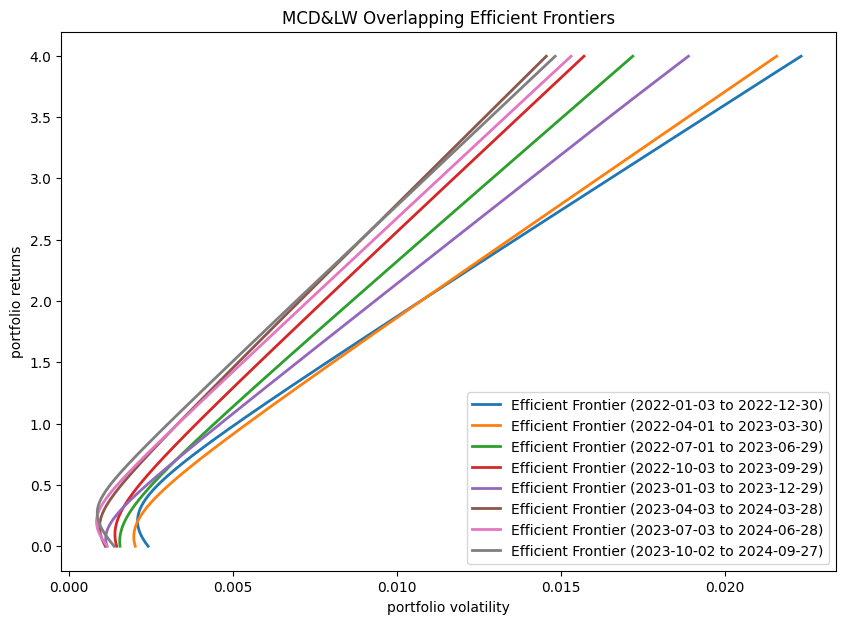

In [568]:
plt.figure(figsize=(10, 7))  # Set a suitable figure size for the combined plot
optimal_weight_mcd_lw = []
for i in range(len(rolling_window)):
    x = mcd_lw_efficient_frontier(rolling_window[i])
    
    # Generate start and end dates for the labels
    start_date_str = rolling_window[i].index.min().strftime('%Y-%m-%d')
    end_date_str = rolling_window[i].index.max().strftime('%Y-%m-%d')
    
    # Plot each efficient frontier on the same plot with a different label for identification
    plt.plot(x[0] , np.arange(0, 4, 0.005), lw=2, label=f"Efficient Frontier ({start_date_str} to {end_date_str})")
    optimal_weight_mcd_lw.append(x[3])
# Add labels and title
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio returns')
plt.title('MCD&LW Overlapping Efficient Frontiers')
# Add a legend to differentiate the frontiers
plt.legend()
# Show the plot
plt.show()

<Figure size 1400x2000 with 0 Axes>

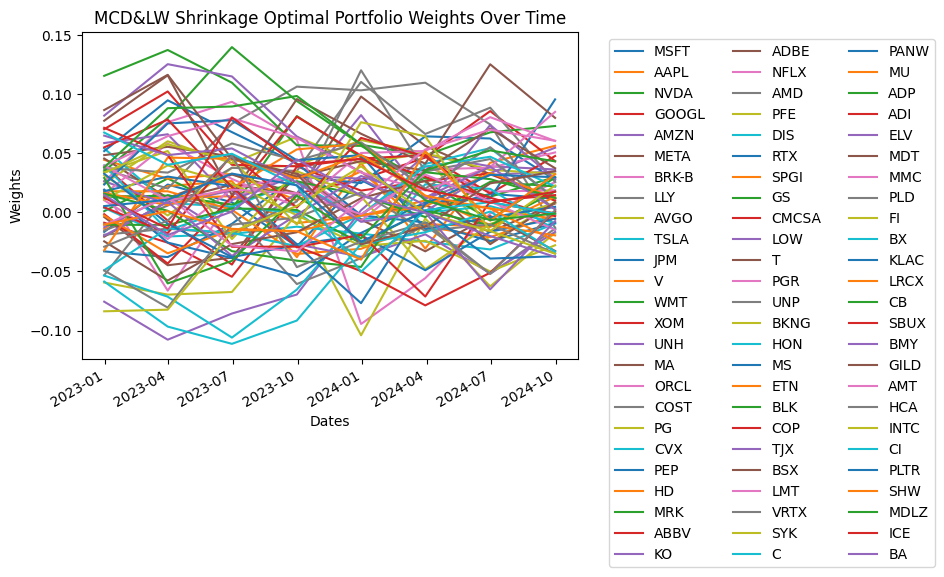

In [569]:
weight_df_mcd_lw = pd.DataFrame(optimal_weight_mcd_lw,index = end_date_index,columns= dataset.columns)
plt.figure(figsize = (14,20))
weight_df_mcd_lw.plot(title='MCD&LW Shrinkage Optimal Portfolio Weights Over Time')
plt.xlabel('Dates')
plt.ylabel('Weights')
#plt.legend().set_visible(False)
plt.legend(dataset.columns, bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 3) 
plt.show()

Text(0.5, 1.0, 'Weightage Standard Deviation for MCD&LW Efficient Frontier')

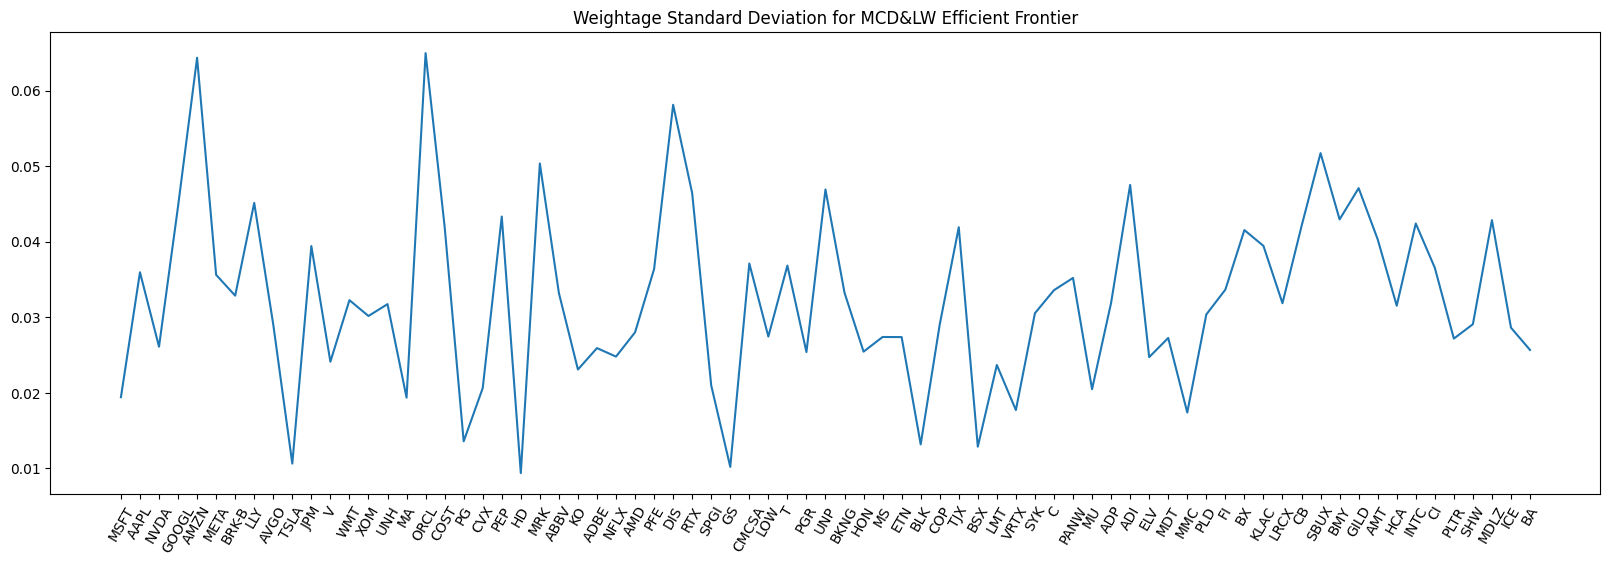

In [571]:
weight_mcd_lw_std = weight_df_mcd_lw.std()
plt.figure(figsize=(20, 6))
weight_mcd_lw_std.plot()
plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
plt.title('Weightage Standard Deviation for MCD&LW Efficient Frontier')

## EWMA method (Omitted)

In [456]:
# ## Define efficient frontier function using MCD

# def ewma_efficient_frontier(data, lambda_=0.94):
#     num_assets = len(data.columns)

#     # Calculate log returns
#     log_return = np.log(data / data.shift(1)).dropna()
#     mu = log_return.mean() * 252
#     mu = mu.values.reshape(-1, 1)

#     ewma_cov = log_return.ewm(span=(2 / (1 - lambda_)) - 1, adjust=False).cov(pairwise=True).iloc[-num_assets:, -num_assets:]
#     ewma_cov = ewma_cov * 252  

#     # Initialize lists to store volatility values and weights for different expected returns
#     vol_eff_front = []
#     largest_weights = []
#     weights_series = []

#     # Efficient frontier loop over different expected returns
#     for r in np.arange(0, 4, 0.005):
#         w = cp.Variable(num_assets)

#         # Define constraints
#         constraints = [
#             cp.sum(w) == 1,        # Sum of weights should equal 1
#             mu.T @ w == r,         # Expected return constraint
#             w >= -1,               # Lower bound for short selling
#             w <= 1                 # Upper bound of 1 for each weight
#         ]

#         # Formulate the optimization problem (minimizing variance: w.T @ (EWMA covariance) @ w)
#         objective = cp.Minimize(cp.quad_form(w, ewma_cov.values))
#         problem = cp.Problem(objective, constraints)

#         # Solve the problem
#         result = problem.solve()

#         # Append the standard deviation (volatility) to the list
#         vol_eff_front.append(np.sqrt(result))

#         # Store weights for each portfolio
#         w_values = w.value
#         weights_series.append(w_values)

#         # Store top weights for optional visualization
#         w_series = pd.Series(w_values, index=data.columns)
#         top_weights = w_series.sort_values(ascending=False).head(5)
#         largest_weights.append(top_weights)

#     # Find the GMVP weights
#     min_vol_index = np.argmin(vol_eff_front)   # Index of minimum volatility
#     gmvp_weights = weights_series[min_vol_index]  # Corresponding weights for GMVP

#     # Retrieve weights at a threshold return of 0.2
#     threshold_index = int(0.2 / 0.005 - 1)
#     threshold_weight = weights_series[threshold_index]

#     return vol_eff_front, largest_weights, gmvp_weights, threshold_weight


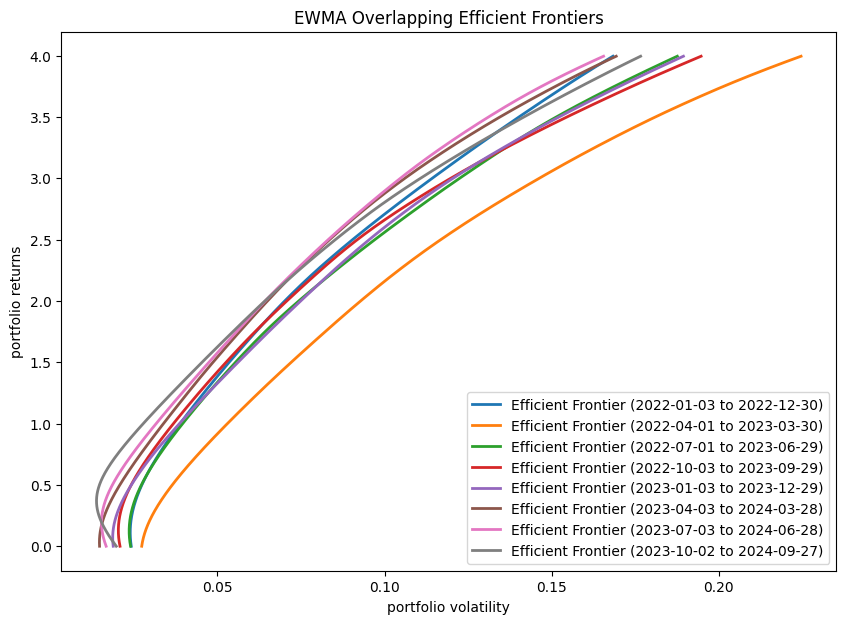

In [457]:
# plt.figure(figsize=(10, 7))  # Set a suitable figure size for the combined plot
# optimal_weight_ewma = []
# for i in range(len(rolling_window)):
#     x = ewma_efficient_frontier(rolling_window[i])
    
#     # Generate start and end dates for the labels
#     start_date_str = rolling_window[i].index.min().strftime('%Y-%m-%d')
#     end_date_str = rolling_window[i].index.max().strftime('%Y-%m-%d')
    
#     # Plot each efficient frontier on the same plot with a different label for identification
#     plt.plot(x[0] , np.arange(0, 4, 0.005), lw=2, label=f"Efficient Frontier ({start_date_str} to {end_date_str})")
#     optimal_weight_ewma.append(x[3])
# # Add labels and title
# plt.xlabel('portfolio volatility')
# plt.ylabel('portfolio returns')
# plt.title('EWMA Overlapping Efficient Frontiers')
# # Add a legend to differentiate the frontiers
# plt.legend()
# # Show the plot
# plt.show()

<Figure size 1400x2000 with 0 Axes>

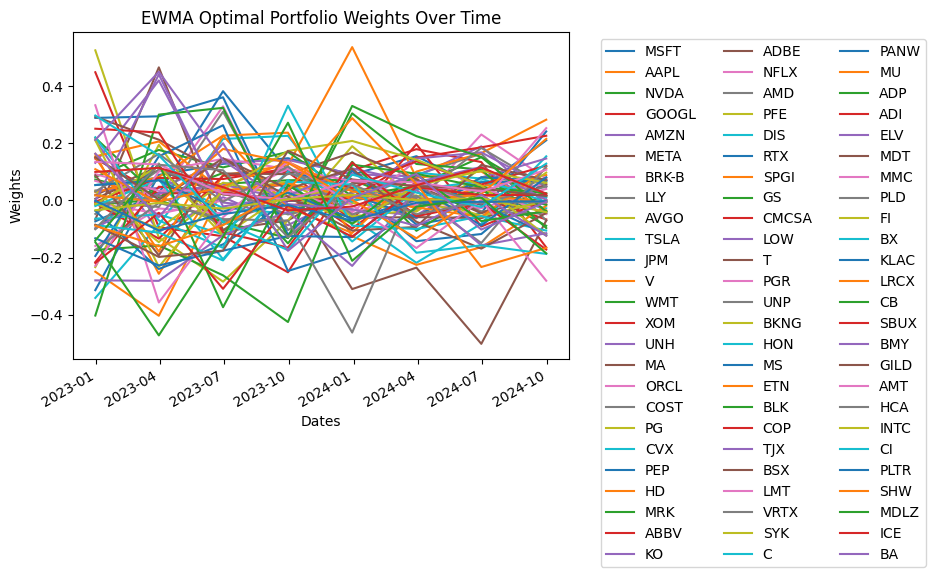

In [459]:
# weight_df_ewma = pd.DataFrame(optimal_weight_ewma,index = end_date_index,columns= dataset.columns)
# plt.figure(figsize = (14,20))
# weight_df_ewma.plot(title='EWMA Optimal Portfolio Weights Over Time')
# plt.xlabel('Dates')
# plt.ylabel('Weights')
# #plt.legend().set_visible(False)
# plt.legend(dataset.columns, bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 3) 
# plt.show()

Text(0.5, 1.0, 'Weightage Standard Deviation for Basic Efficient Frontier')

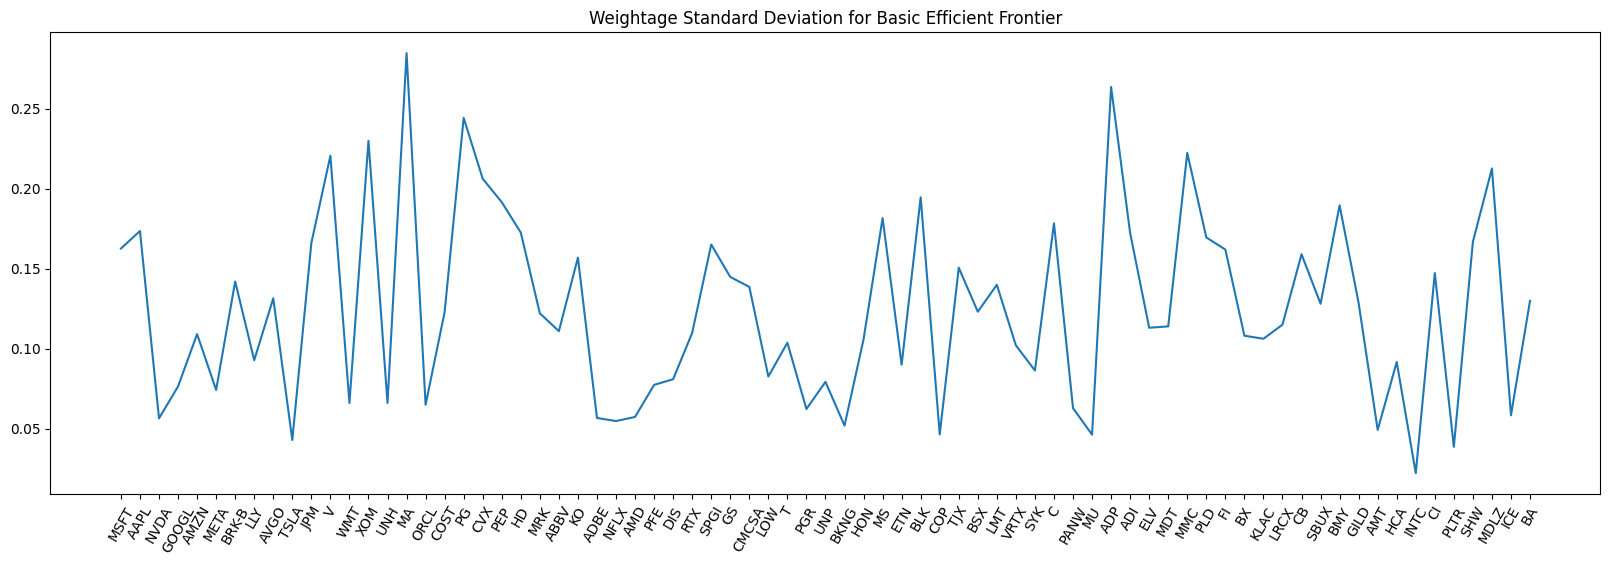

In [460]:
# weight_ewma_std = weight_df_ewma.std()
# plt.figure(figsize=(20, 6))
# weight_ewma_std.plot()
# plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
# plt.title('Weightage Standard Deviation for Basic Efficient Frontier')

## STD of weightage changing for different equities across different approaches

Text(0.5, 1.0, 'Weightage Standard Deviation for MCD&LW Efficient Frontier')

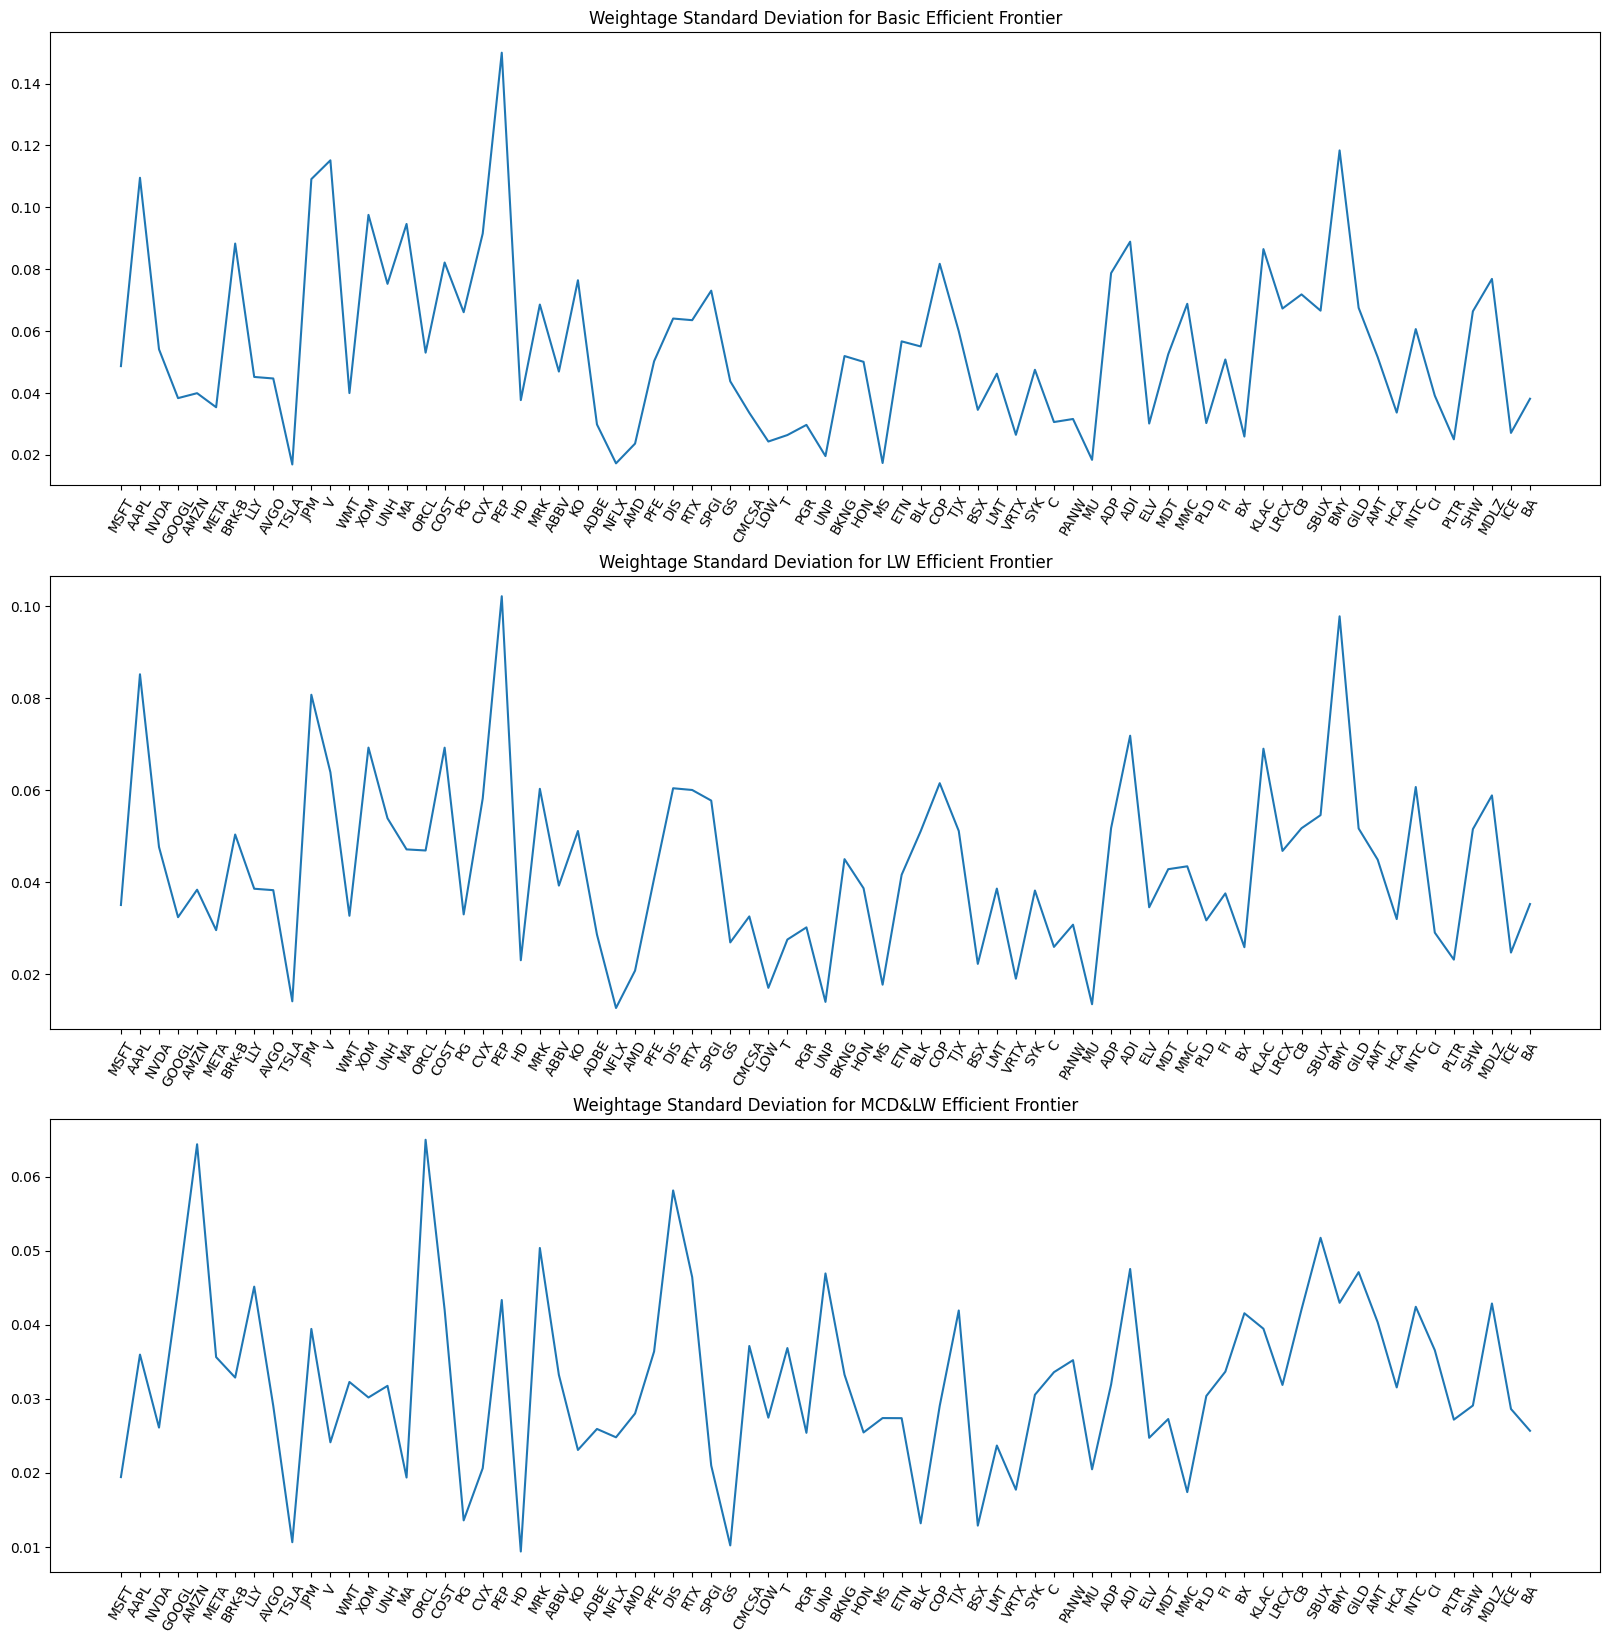

In [572]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
weight_std.plot(title='Weightage Standard Deviation for Basic Efficient Frontier')
plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
plt.subplot(3,1,2)
weight_lw_std.plot()
plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
plt.title('Weightage Standard Deviation for LW Efficient Frontier')
plt.subplot(3,1,3)
weight_mcd_lw_std.plot()
plt.xticks(range(len(weight_std.index)), weight_std.index, rotation=60)
plt.title('Weightage Standard Deviation for MCD&LW Efficient Frontier')

# A more generalized function

In [7]:
## Assume the transction cost is a portion of weightage change
## Assume transction cost is 0.005%
def calculate_covariance(returns, method="empirical", **kwargs):
    if method == "Empirical":
        return returns.cov() * 252
    elif method == "LW":
        lw = LedoitWolf()
        lw_cov = lw.fit(returns).covariance_*252
        lw_cov = pd.DataFrame(lw_cov, index = dataset.columns, columns = dataset.columns)
        return lw_cov
    elif method == "MCD&LW":
        mcd = MinCovDet()
        mcd_cov = mcd.fit(returns).covariance_ * 252
        lw = LedoitWolf()
        lw.fit(mcd_cov)
        combined_covariance = lw.covariance_
        combined_covariance_df = pd.DataFrame(combined_covariance, index=dataset.columns, columns=dataset.columns)
        return combined_covariance_df
        


## Compare Model performance with the same target return and consider add in transaction cost 
### Goal --> Minimize (risk and transaction cost) at the level of return

In [34]:
# Portfolio optimization with optional transaction costs
def optimize_portfolio(mu, cov_matrix, target_return, prev_weights=None, transaction_cost=0.0):
    num_assets = len(mu)
    weights = cp.Variable(num_assets)
    
    # Define the portfolio return and variance
    portfolio_return = mu.T @ weights
    portfolio_variance = cp.quad_form(weights, cov_matrix)

    # Add transaction cost (penalty on turnover from previous weights)
    if transaction_cost > 0 and prev_weights is not None:
        turnover_cost = cp.norm(weights - prev_weights, 1) * transaction_cost
    else:
        turnover_cost = 0

    # Define constraints
    constraints = [portfolio_return == target_return, cp.sum(weights) == 1, weights >= -1, weights<=1]

    # Formulate and solve the problem
    problem = cp.Problem(cp.Minimize(portfolio_variance + turnover_cost), constraints)
    problem.solve()

    # Extract portfolio risk, weights, and turnover
    portfolio_risk = cp.sqrt(portfolio_variance).value
    optimized_weights = weights.value
    actual_turnover = np.abs(optimized_weights - prev_weights).sum() if prev_weights is not None else 0
    
    return portfolio_return.value, portfolio_risk, optimized_weights, actual_turnover


In [45]:
performance_data = dataset[dataset.index > '2023']
performance_data_return = np.log(performance_data/performance_data.shift(1)).dropna()
cumulative_returns = pd.DataFrame(index=performance_data_return.index)
## metrics for robustness
turnover_rate = []
risk = [] ## average annualized risk 
max_drawdown = []
sharpe_ratio = []
risk_free = 0.035 ## assume risk free rate = 3.5%
end_return = []

# Loop through covariance methods and calculate cumulative returns
for method in ["Empirical", "LW", "MCD&LW"]:
    prev_weights = None
    cumulative_return_series = []
    turnover = 0
    port_risk = []

    for i in range(1,len(rolling_window)):
        # Define expected returns and target return for each window
        log_return = np.log(rolling_window[i-1]/rolling_window[i-1].shift(1)).dropna()
        mu = log_return.mean() * 252  # Annualized mean return
        mu = mu.values.reshape(-1, 1)
        target_return = 0.5
        # Calculate covariance matrix and optimize portfolio
        cov_matrix = calculate_covariance(log_return, method=method)

        x = optimize_portfolio(mu, cov_matrix, target_return, prev_weights=prev_weights, transaction_cost = 0.005)
        # Calculate daily portfolio returns using optimized weights
        current_return = performance_data_return[(performance_data_return.index >= end_date_index[i-1]) & (performance_data_return.index <= end_date_index[i])]
        portfolio_returns =  np.dot(current_return, x[2])
        cumulative_return_series.extend(portfolio_returns)
        # Update previous weights for the next quarter
        prev_weights = x[2]
        port_risk.append(x[1]) ## annualized risk for the current rolling window
        turnover += x[3]
    # Calculate cumulative returns for the series
    cumulative_return_series = cumulative_return_series[2:]
    cumulative_returns[method] = np.cumsum((cumulative_return_series)) + 1  # Start cumulative returns from 1
    ## metrics for robustness
    turnover_rate.append(turnover)
    risk.append(sum(port_risk)/len(port_risk))
    running_max = cumulative_returns[method].cummax()
    drawdown = (cumulative_returns[method] - running_max) / running_max
    max_drawdown.append(drawdown.min())
    excess_return = [i - risk_free/252 for i in cumulative_return_series]
    sharpe_ratio.append(np.mean(excess_return)/np.std(excess_return)*np.sqrt(252))
    end_return.append(cumulative_returns[method].iloc[-1])

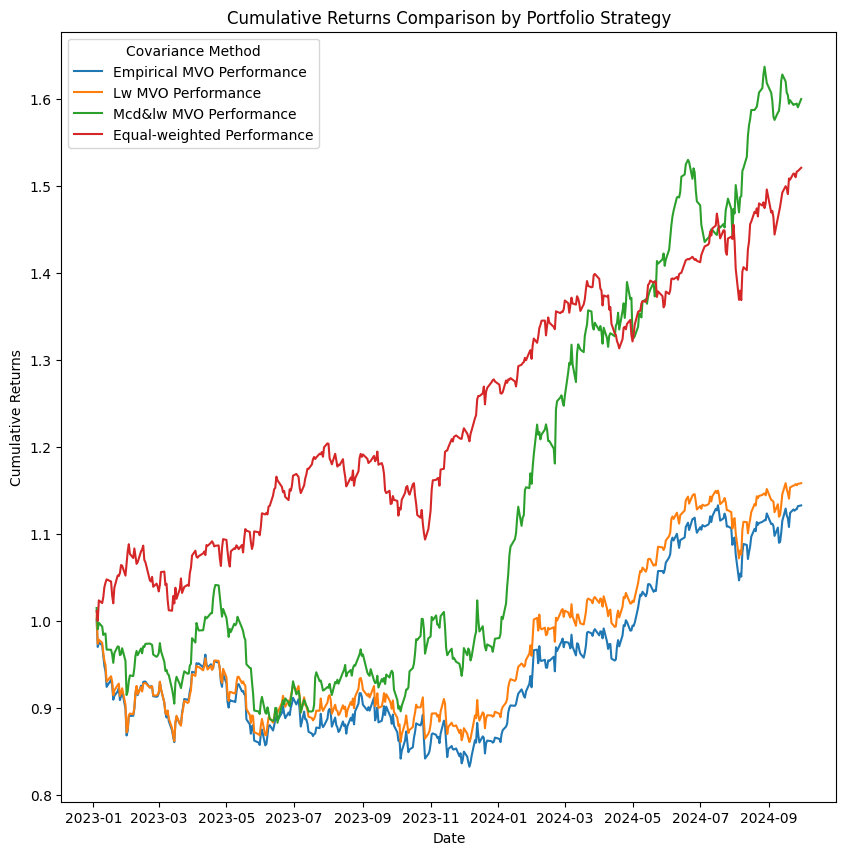

In [47]:
equal_weight = np.ones(len(dataset.columns))/(len(dataset.columns))
equal_weight_performance = np.cumprod(1+ np.dot(performance_data_return,equal_weight))
# Plot cumulative returns for each method
plt.figure(figsize=(10, 10))
for method in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[method], label=f"{method.capitalize()} MVO Performance")
plt.plot(performance_data_return.index,equal_weight_performance,label = 'Equal-weighted Performance')
# Customize plot
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns Comparison by Portfolio Strategy")
plt.legend(title="Covariance Method")
plt.show()

In [48]:
turnover_rate.append(0)
equalp_cov = performance_data_return.cov()*252
equalp_risk = np.sqrt(equal_weight.T@(equalp_cov@equal_weight))
equal_daily_return = np.dot(performance_data_return,equal_weight)
equal_excess = equal_daily_return - risk_free/252
sharpe_ratio.append(np.mean(equal_excess)/np.std(equal_excess)*np.sqrt(252))
risk.append(equalp_risk)
equal_running_max = equal_weight_performance.max()
drawdown = (equal_running_max - running_max) / running_max
max_drawdown.append(drawdown.min())
end_return.append(equal_weight_performance[-1])

/var/folders/jg/3wc1lk5d4kbdgzk4sq3jpx5w0000gn/T/ipykernel_24166/2944830804.py:34: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(bars, labels, loc='upper left', bbox_to_anchor=(1.05, 1))


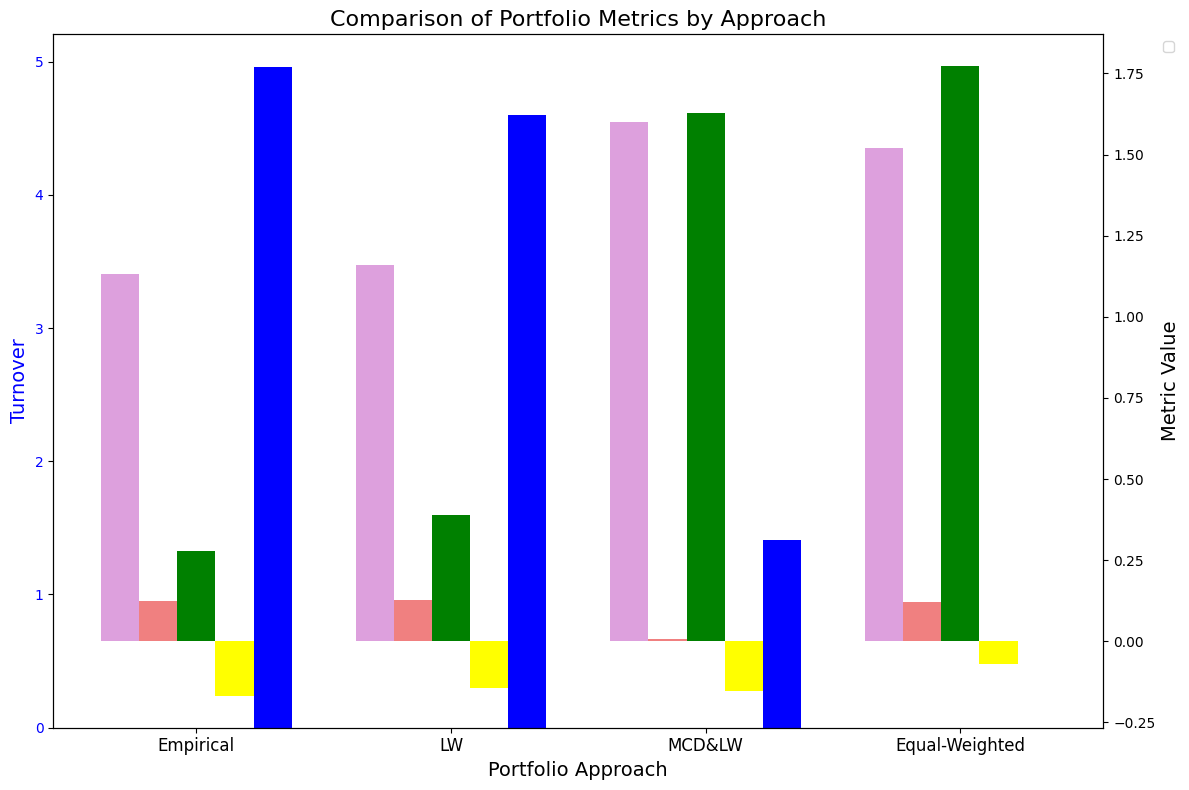

In [49]:
## Plot metrics for robustness
approaches = ['Empirical', 'LW', 'MCD&LW', 'Equal-Weighted']

# Set up the figure and dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Number of approaches
num_approaches = len(approaches)
bar_width = 0.15  # Width of each bar (adjusted to fit 5 bars)
index = np.arange(num_approaches)  # The x locations for the groups

# Plot Turnover on the primary y-axis (ax1)
bars1 = ax1.bar(index + 2 * bar_width, turnover_rate, bar_width, label='Turnover', color='blue')
ax1.set_ylabel('Turnover', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for Return, Risk, Sharpe Ratio, and Max Drawdown
ax2 = ax1.twinx()
bars2 = ax2.bar(index - 2 * bar_width, end_return, bar_width, label='Cumulative Return', color='plum')
bars3 = ax2.bar(index - bar_width, risk, bar_width, label='Risk (Annualized)', color='lightcoral')
bars4 = ax2.bar(index, sharpe_ratio, bar_width, label='Sharpe Ratio', color='green')
bars5 = ax2.bar(index + bar_width, max_drawdown, bar_width, label='Max Drawdown', color='yellow')

# Set labels and title
ax1.set_xlabel('Portfolio Approach', fontsize=14)
ax2.set_ylabel('Metric Value', fontsize=14)
ax1.set_title('Comparison of Portfolio Metrics by Approach', fontsize=16)
ax1.set_xticks(index)
ax1.set_xticklabels(approaches, fontsize=12)

# Add a combined legend
bars = bars1 + bars2 + bars3 + bars4 + bars5
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper left', bbox_to_anchor=(1.05, 1))

# Display the plot
plt.tight_layout()
plt.show()

In [50]:
end_return

[1.1331119652904584,
 1.1585943759294126,
 1.6000966192099146,
 1.5211371453594609]

In [51]:
risk

[0.12350326815330319,
 0.1258391019239901,
 0.006660836717683328,
 0.12099374156070468]

In [52]:
sharpe_ratio

[0.27870238083146204,
 0.3907745117973952,
 1.6289122295227678,
 1.7732232275643829]

In [53]:
max_drawdown

[-0.1691017141497646,
 -0.14383453558907253,
 -0.1520586761978536,
 -0.07092074396912934]

In [54]:
turnover_rate

[4.956683106962689, 4.601756731026752, 1.4096778656709126, 0]